**Initialization**

In [2]:
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

**Task 1: Data set**

To prepare the data for our training of the CNN, we used the knowledge gained in our Data_Set_Test. Because we saw that in most cases the pictures are much smaller than 394 x 394 and therefore a lot of black matter gets up we decided to choose a smaller edge length of 300. So our computing time could be shortened a bit, but the size is still sufficient to get an accuracy of about 95%. The original images with bigger edge length need to be reduced in size, put not cropped. Thats why we took the function resize from the tensorflow libary.


In [3]:
# Input pipeline
batch_size = 64

raw_dataset = tfds.load('Malaria', split='train', as_supervised = True)    # Name the split parameter to get a tf.dataset with tuples. Otherwise one gets a dictionary.

# Resizes the images to a quadratic shape of 300x300 pixels. 
padded_images = raw_dataset.map(lambda inp, tar: tf.image.resize(inp, [300, 300]))

# Normalizes/ Standardizes the images with a mean of zero and a standard deviation of 1.
padded_images = padded_images.map(lambda img: tf.image.per_image_standardization(img)) 

# One-hot encoded targets
one_hot_targets = raw_dataset.map(lambda inp, tar: tf.one_hot(tar, 2))


# Seperates the inputs (images) and targets into training and test data.
splitting_limit_train_test_data = 22000
training_dataset_inputs = padded_images.take(splitting_limit_train_test_data)      # new datasets with all items up to the splitting limit
training_dataset_targets = one_hot_targets.take(splitting_limit_train_test_data)   

test_dataset_inputs = padded_images.skip(splitting_limit_train_test_data)          # new datasets with all items from the splitting limit
test_dataset_targets = one_hot_targets.skip(splitting_limit_train_test_data)       


# Zips together, shuffles, batches and prefetches the training and test datasets.
training_dataset = tf.data.Dataset.zip((training_dataset_inputs, training_dataset_targets))
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(buffer_size = batch_size)
training_dataset = training_dataset.prefetch(32)

test_dataset = tf.data.Dataset.zip((test_dataset_inputs, test_dataset_targets))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size = batch_size)
test_dataset = test_dataset.prefetch(32)   

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete3W40D5/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


**Task 2: Model**

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Description: The class Model describes a convolutional neural network with a feature extractor and 
#              a classifier.
#              @class variables: -
#              @object variables: conv_1, max_pool_1, conv_2, max_pool_2, conv_3, max_pool_3, conv_4, 
#                                 max_pool_4, global_pool, output
#              @functions: call
class Model(Model): 
  
    def __init__(self):
        super(Model, self).__init__()

        # Feature extractor
        self.conv_1 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.relu, input_shape=(300, 300, 3))
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.tanh)
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.conv_3 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.tanh)
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.conv_4 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, activation=tf.keras.activations.relu)
        self.max_pool_4 = tf.keras.layers.MaxPool2D()

        # Classifier
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)


    # Description: This function conducts one forward-step of the model. 
    #              A python decorator (@tf.function) is used to bundle multiple computations into one computational graph.
    #              @parameters: (input) x
    #              @returns: (prediction) x
    @tf.function
    def call(self, x):
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.max_pool_4(x)

        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

**Task 3: Training**

In [5]:
# Description: This function trains an object of the class Model. It conducts a forward-step and the backpropagation 
#              throughout the network. Additionally, it determines the average training loss and accuracy.
#              @parameters: model, training_data, loss_fn, optimizer
#              @returns: training_loss, training_accuracy
def training_step(model, training_data, loss_fn, optimizer):
  training_losses = []
  training_accuracies = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction = model(input)
      current_training_loss = loss_fn(target, prediction)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

    current_training_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    training_accuracies.append(np.mean(current_training_accuracy))   
  
  training_loss = np.mean(training_losses)
  training_accuracy = np.mean(training_accuracies)
  return training_loss, training_accuracy


# Description: This function determines the average test loss and accuracy of an object of the class Model.
#              @parameters: model, test_data, loss_fn
#              @returns: test_loss, test_accuracy
def test(model, test_data, loss_fn):
  test_losses = []
  test_accuracies = []

  for (input, target) in test_data:
    prediction = model(input)
    
    current_test_loss = loss_fn(target, prediction)
    test_losses.append(current_test_loss.numpy())

    current_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    test_accuracies.append(np.mean(current_test_accuracy))   
    
  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)
  return test_loss, test_accuracy

In [6]:
# Description: This part creates an object of the class Model called model and executes the training and testing of the model in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
tf.keras.backend.clear_session()

model = Model()
n_epochs = 30
learning_rate = 0.00008
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate, amsgrad=True)    # Adam = Adaptive Moment Estimation

training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    training_loss, training_accuracy = training_step(model, training_dataset, loss_fn, optimizer)
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


**Task 4: Visualization**

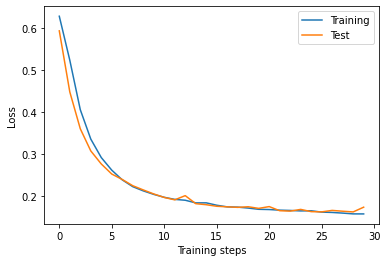

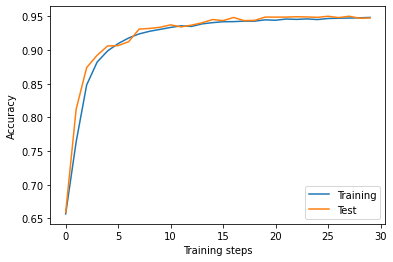

In [7]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1, line2),("Training", "Test"))
plt.show()